In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split

In [5]:
from relaxed.analysis import setup, get_quantiles, get_am, get_an_from_am, get_lam, get_ma, get_gradient, get_fractional_tdyn

# predictions with gradients

## Collect data

In [6]:
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')
xoff = hcat.cat['xoff']
cvir = hcat.cat['cvir']
eta = hcat.cat['eta']


# obtain ma
ma, keep1 = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]

#lam 
lam, keep2 = get_lam(am)

# cuts
ma = ma[keep1 & keep2]
am = am[keep1 & keep2]
hcat.cat = hcat.cat[keep1 & keep2]
cvir, xoff, eta = cvir[keep1 & keep2], xoff[keep1 & keep2], eta[keep1 & keep2]

# gradients
grads1 = get_gradient(np.log(ma), np.log(scales), k=1, acc=2)
grads4 = get_gradient(np.log(ma), np.log(scales), k=4, acc=2)
grads20 = get_gradient(np.log(ma), np.log(scales), k=20, acc=2)


print(am.shape, ma.shape, grads4.shape, grads20.shape, mass_bins.shape, cvir.shape, xoff.shape, eta.shape)

(19712, 98) (19712, 171) (19712, 171) (19712, 171) (98,) (19712,) (19712,) (19712,)


In [7]:
# train/test split
from sklearn.model_selection import train_test_split

am_train, am_test, grads1_train, grads1_test, grads4_train, grads4_test, grads20_train, grads20_test, eta_train, eta_test, xoff_train, xoff_test, cvir_train, cvir_test  = \
train_test_split(am, grads1, grads4, grads20, eta, xoff, cvir, test_size=0.2)
print(am_train.shape, grads4_train.shape, grads20_train.shape, eta_train.shape)

(15769, 98) (15769, 171) (15769, 171) (15769,)


## Train!

In [11]:
from relaxed.models import training_suite

In [12]:
train_features1 = np.hstack([am_train, grads1_train])
test_features1 = np.hstack([am_test, grads1_test])
train_features4 = np.hstack([am_train, grads4_train])
test_features4 = np.hstack([am_test, grads4_test])
train_features20 = np.hstack([am_train, grads20_train])
test_features20 = np.hstack([am_test, grads20_test])

In [13]:
train_features1.shape

(15769, 269)

In [14]:
#let's start with the eta prediction. 
data = {
    'cam_1/2': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads1': {
        'xy': (train_features1, eta_train), 'n_features': train_features1.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads4': {
        'xy': (train_features4, eta_train), 'n_features': train_features4.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads20': {
        'xy': (train_features20, eta_train), 'n_features': train_features20.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'lognormal': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}}
}
eta_models = training_suite(data)

In [23]:
#xoff is next.
data = {
    'cam_1/2': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads1': {
        'xy': (train_features1, xoff_train), 'n_features': train_features1.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads4': {
        'xy': (train_features4, xoff_train), 'n_features': train_features4.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads20': {
        'xy': (train_features20, xoff_train), 'n_features': train_features20.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'lognormal': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}}
}
xoff_models = training_suite(data)

In [24]:
#xoff is next.
data = {
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads1': {
        'xy': (train_features1, cvir_train), 'n_features': train_features1.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads4': {
        'xy': (train_features4, cvir_train), 'n_features': train_features4.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_grads20': {
        'xy': (train_features20, cvir_train), 'n_features': train_features20.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}}
}
cvir_models = training_suite(data)

## Plots

In [21]:
# test_data is a dictionary containing the information for testing each model.
def combined_histogram(test_data: dict, y_test, trained_models, n_bins=31, latex_var="", xrange=(-2, 2)):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    bins = None
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = (y_pred - y_test) / y_test
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        print(f'{name} corr: {scipy.stats.spearmanr(y_pred, y_test)[0]}')
        RMSE =  np.sqrt(np.mean(((y_pred - y_test) / y_test)**2))
        print(f'{name} RMSE: {RMSE}\n')
        label = f'{label}, RMSE={RMSE:.3f}'
        draw_histogram(ax, x, vline=None, label=label, color=color, bins=bins, density=False)
        
    ax.axvline(0, color='k', ls='--')
    ax.legend(loc='best', prop={'size':20})
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / {v_test}$", size=28)

linear_no_grads corr: 0.6778528487365172
linear_no_grads RMSE: 0.04951806886064789

linear_grads1 corr: 0.6896279022700659
linear_grads1 RMSE: 0.04957981179174122

linear_grads4 corr: 0.6929582784370681
linear_grads4 RMSE: 0.04781310842698476

linear_grads20 corr: 0.6953295621790578
linear_grads20 RMSE: 0.047678615173883304



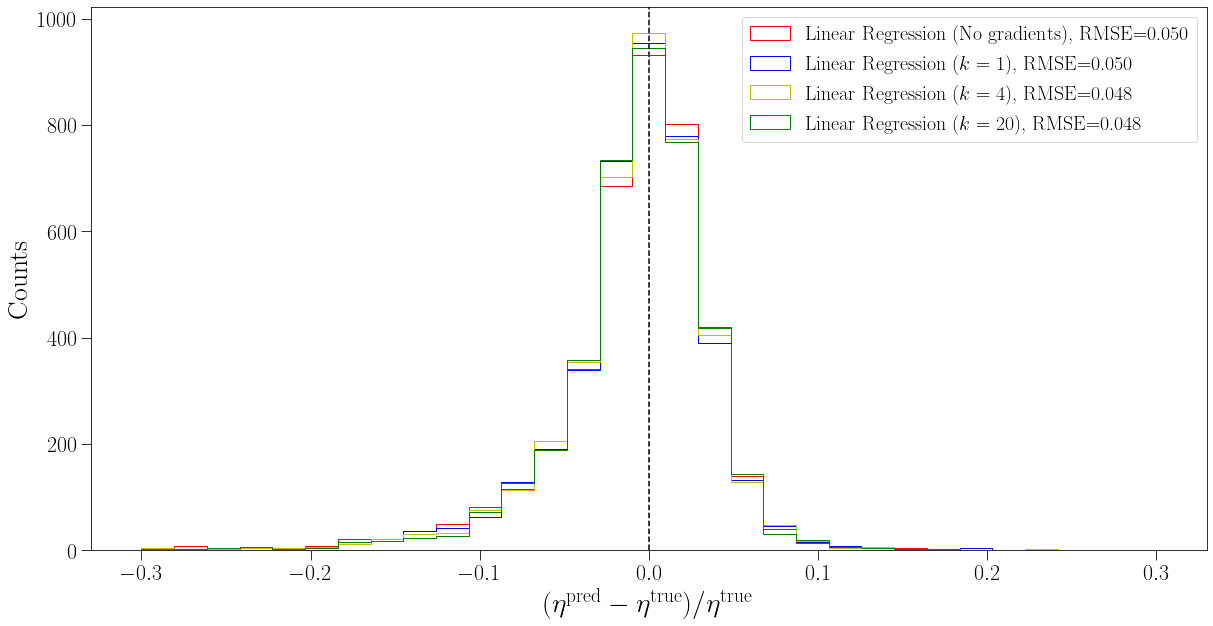

In [22]:
test_data = {'linear_no_grads': (am_test, r"\rm Linear Regression (No gradients)", 'r'),
            'linear_grads1': (test_features1, r"\rm Linear Regression ($k=1$)", 'b'),
            'linear_grads4': (test_features4, r"\rm Linear Regression ($k=4$)", 'y'),
            'linear_grads20': (test_features20, r"\rm Linear Regression ($k=20$)", 'g'),}
combined_histogram(test_data, eta_test, eta_models, latex_var=r'\eta', n_bins=31, xrange=(-0.3, 0.3))

linear_no_grads corr: 0.7657513168809257
linear_no_grads RMSE: 0.32420248704611987

linear_grads1 corr: 0.7975921473610179
linear_grads1 RMSE: 0.33695131177888027

linear_grads4 corr: 0.7980532292451723
linear_grads4 RMSE: 0.3372956349802918

linear_grads20 corr: 0.7930454071986293
linear_grads20 RMSE: 0.3458962986651226



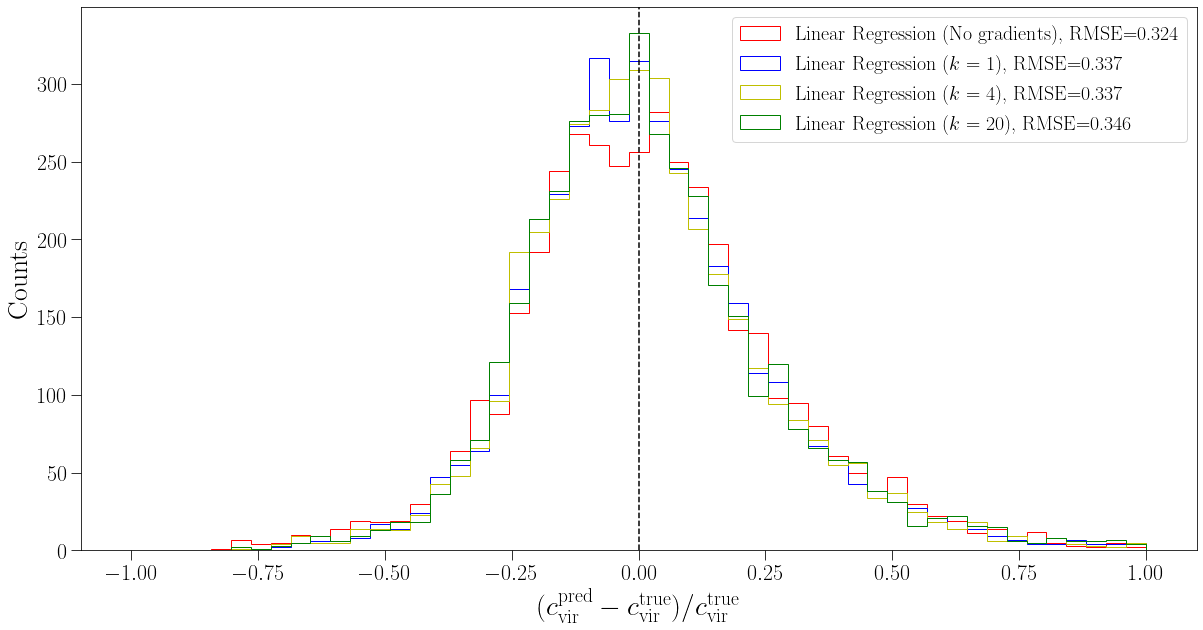

In [26]:
test_data = {'linear_no_grads': (am_test, r"\rm Linear Regression (No gradients)", 'r'),
            'linear_grads1': (test_features1, r"\rm Linear Regression ($k=1$)", 'b'),
            'linear_grads4': (test_features4, r"\rm Linear Regression ($k=4$)", 'y'),
            'linear_grads20': (test_features20, r"\rm Linear Regression ($k=20$)", 'g'),}
combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=51, xrange=(-1, 1))

linear_no_grads corr: 0.4846030978585079
linear_no_grads RMSE: 0.869938209947137

linear_grads1 corr: 0.47365179912210914
linear_grads1 RMSE: 0.8779712662574573

linear_grads4 corr: 0.4749173262559153
linear_grads4 RMSE: 0.8857713238870563

linear_grads20 corr: 0.47491213047356573
linear_grads20 RMSE: 0.8699750288649907



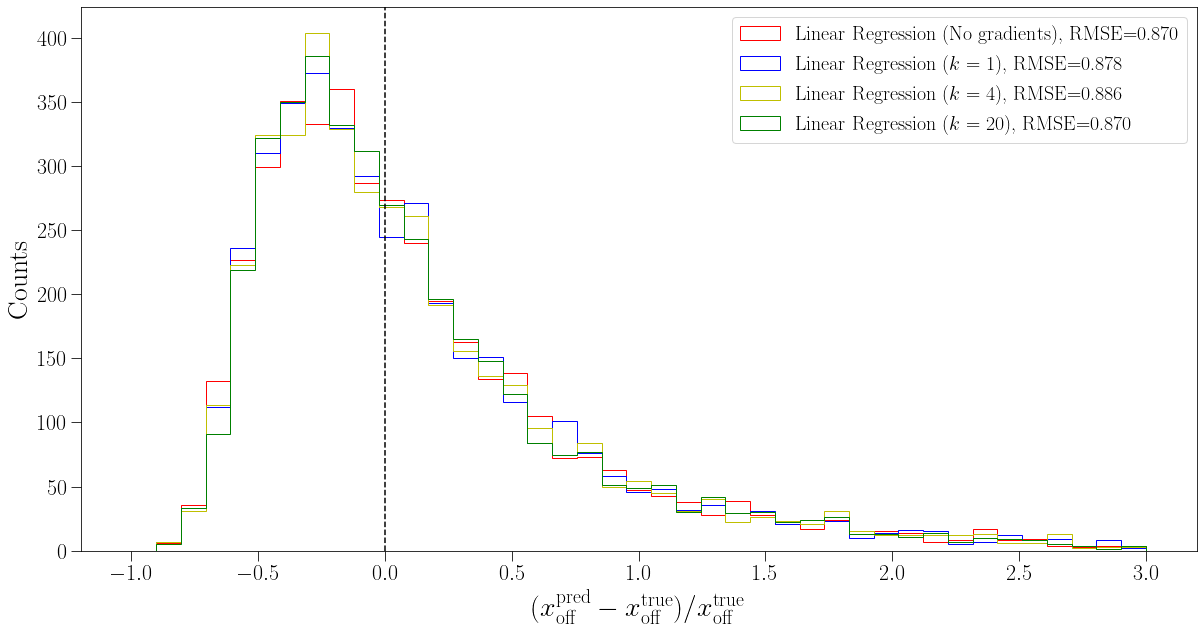

In [29]:
test_data = {'linear_no_grads': (am_test, r"\rm Linear Regression (No gradients)", 'r'),
            'linear_grads1': (test_features1, r"\rm Linear Regression ($k=1$)", 'b'),
            'linear_grads4': (test_features4, r"\rm Linear Regression ($k=4$)", 'y'),
            'linear_grads20': (test_features20, r"\rm Linear Regression ($k=20$)", 'g'),}
combined_histogram(test_data, xoff_test, xoff_models, latex_var=r'x_{\rm off}', n_bins=41, xrange=(-1, 3))